In [1]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`
┌ Info: Precompiling BpAlignGpu [5a3eb610-29b2-4cbe-8ba2-ea97f65fa95d]
└ @ Base loading.jl:1423


In [2]:
using CUDA
CUDA.device!(1)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


CuDevice(1): TITAN RTX

In [3]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm")
muext = 0.00
muint = 2.50;

In [4]:
CUDA.allowscalar(false)

In [5]:
using Plots

# -------------- Choose family --------------

In [6]:
#open("/home/louise/MSA/Data/test/PF00684/")
#L = 67; 

#J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

#delta = 50;
#al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
#M = length(al)

#using DelimitedFiles
#Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
#lambda_o = Lambda_all[:,1];
#lambda_e = Lambda_all[:,2];


In [7]:
open("/home/louise/MSA/Data/test/PF00397/")
L = 31; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

delta = 5;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
M = length(al)

using DelimitedFiles
Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [8]:
##Random Data
#(N, L) = (6, 5) 
##(N, L) = (161, 67)

#lambda_o = ones(L)
#lambda_e = ones(L)
#H = rand(q,L)
#J = rand(q,q,L,L)
#J = J .+ permutedims(J, (2,1,4,3));

# -------------- Load solutions DCAlign --------------

In [9]:
using DelimitedFiles
fam = readdlm("PF00397_sols.txt");
samples = fam[:,1];

In [10]:
(Nmin, Nmax) = extrema([length(al[idx0][2]) for idx0 in 1:M])
ibig = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmax)[1]
ismall = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmin)[1];

# -------------- one sequence, one epsilon --------------

In [11]:
ind = 2
idx0 = samples[ind]

29277

In [12]:
seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
@show seq
N = length(al[idx0][2])

seq = LPPGWEERTHTD-GRIFYINHNIKRTQWEDP
SDLGPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRLQNV


40

In [13]:
pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

ParamModel{Float32}[L=31 N=40 q=21 size=1.619 MiB]

In [14]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false

ϵ = -2.5
xnsol = fill((0, 0), L);
epscoupling=(false, T(ϵ), xnsol)
#epscoupling=(true, T(ϵ), xnsol_0)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=false
-------------

In [15]:
bpm = BPMessages(seq, pm, pa)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=31 N=40 ongpu=true size=53.492 MiB]

In [16]:
#find ground state
iters = 700
minpol = 0.90
nmax = 30
minbet = 0.02
beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet);


beta = 0.0
converged: err=0.0009929091, tol=0.001, nbiter=53
(polar, energy) = (0.037837934f0, 41.278538f0)
beta = 0.1
converged: err=0.0009988695, tol=0.001, nbiter=39
(polar, energy) = (0.049982883f0, 40.304417f0)
beta = 0.2
converged: err=0.00096821785, tol=0.001, nbiter=45
(polar, energy) = (0.07134466f0, 13.019621f0)
beta = 0.30000000000000004
converged: err=0.0009979904, tol=0.001, nbiter=39
(polar, energy) = (0.107840866f0, -26.337738f0)
beta = 0.4
converged: err=0.0009924769, tol=0.001, nbiter=222
(polar, energy) = (0.8433814f0, -61.463226f0)
beta = 0.5
converged: err=0.0009621382, tol=0.001, nbiter=168
(polar, energy) = (0.94650483f0, -61.463226f0)


In [17]:
beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ

(0.5, 0.0009621382f0, 0.94650483f0, -61.463226f0, 0, -53.62462f0, 0.15120697021484375)

In [18]:
P = fill(fill(0.0, 0:1,0:N+1), L)
if check_ϵ > 0
    println("need decimation, check=", check_ϵ)
    BpAlignGpu.reshape_T3(bel_ϵ,P);
    s, P = BpAlignGpu.decimate_post(seq, P, L, q, N, false);
    sol_decim = BpAlignGpu.decodeposterior(P, seq.strseq)
    xn_decim = BpAlignGpu.convertseqtoxnsol(sol_decim, pm)
    c = BpAlignGpu.check_sr!(xn_decim, L, N)
    @show sum(c)

end

In [30]:
xnsol_0 = xnsol_ϵ;
bel_0 = bel_ϵ;

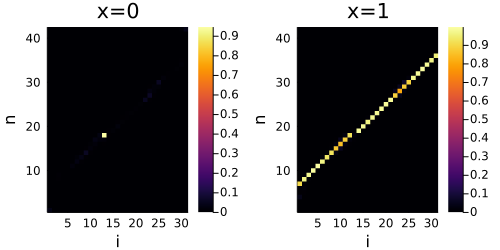

In [31]:
p0 = heatmap(bel_ϵ[:,1,:], xlabel="i", ylabel="n", title="x=0")
p1 = heatmap(bel_ϵ[:,2,:], xlabel="i", ylabel="n", title="x=1")
p = plot(p0, p1, size=(500,250))

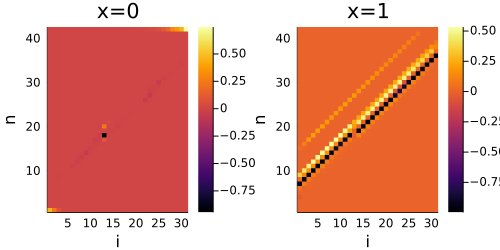

In [47]:
p00 = heatmap(bel_ϵ[:,1,:] .- bel_0[:,1,:], xlabel="i", ylabel="n", title="x=0")
p01 = heatmap(bel_ϵ[:,2,:] .- bel_0[:,2,:], xlabel="i", ylabel="n", title="x=1")
p = plot(p00, p01, size=(500,250))

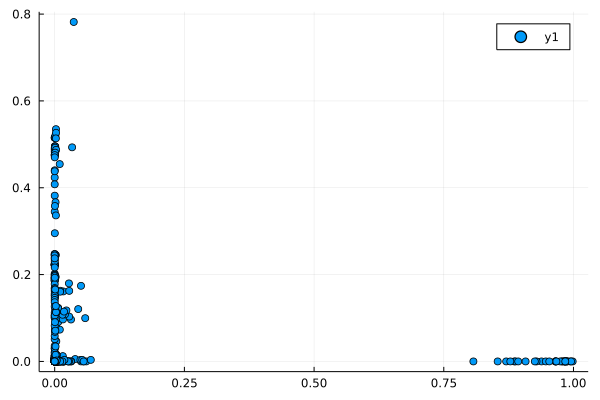

In [77]:
scatter(bel_0[:], bel_ϵ[:])

# -------------- Loop over sequences --------------

In [32]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:mf  
beta=T(0.0)
verbose=false
xnsol = fill((0, 0), L);
epscoupling=(false, T(0.0), xnsol)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=mf
beta=0.0
verbose=false
epscoupling=false
-------------

In [33]:
betas_seq = []
errs_seq = []
polars_seq = []
ens_seq = []
check_seq = []
U_seq = []
S_seq = []

inds = 1:60

xnsols_seq = fill((0, 0), L, length(inds))
bels_seq = zeros(Nmax+2,2,L, length(inds));

In [101]:
nsamp = 3
samps = rand(1:M, nsamp)

3-element Vector{Int64}:
 52269
 13569
 29245

In [104]:
for (i,idx0) in pairs(samps)
    @show (i,idx0)
end

(i, idx0) = (1, 52269)
(i, idx0) = (2, 13569)
(i, idx0) = (3, 29245)


In [ ]:
a
for (i,idx0) in pairs(samples[inds])
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    @show i, idx0, N
end

In [34]:
for (i,idx0) in pairs(samples[inds])
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    @show i, idx0, N
end

(i, idx0, N) = (1, 46958, 40)
(i, idx0, N) = (2, 29277, 40)
(i, idx0, N) = (3, 37570, 40)
(i, idx0, N) = (4, 47888, 40)
(i, idx0, N) = (5, 40717, 39)
(i, idx0, N) = (6, 33094, 39)
(i, idx0, N) = (7, 8776, 40)
(i, idx0, N) = (8, 58353, 41)
(i, idx0, N) = (9, 1853, 40)
(i, idx0, N) = (10, 35008, 40)
(i, idx0, N) = (11, 43976, 40)
(i, idx0, N) = (12, 30389, 40)
(i, idx0, N) = (13, 1897, 38)
(i, idx0, N) = (14, 24786, 40)
(i, idx0, N) = (15, 26725, 40)
(i, idx0, N) = (16, 38605, 40)
(i, idx0, N) = (17, 21091, 40)
(i, idx0, N) = (18, 7660, 40)
(i, idx0, N) = (19, 27074, 40)
(i, idx0, N) = (20, 15620, 39)
(i, idx0, N) = (21, 42466, 40)
(i, idx0, N) = (22, 28154, 41)
(i, idx0, N) = (23, 20620, 38)
(i, idx0, N) = (24, 4506, 39)
(i, idx0, N) = (25, 40770, 39)
(i, idx0, N) = (26, 28362, 40)
(i, idx0, N) = (27, 45448, 40)
(i, idx0, N) = (28, 41291, 40)
(i, idx0, N) = (29, 24651, 41)
(i, idx0, N) = (30, 31544, 40)
(i, idx0, N) = (31, 31164, 41)
(i, idx0, N) = (32, 41725, 39)
(i, idx0, N) = (33, 23

In [35]:
iters = 700
minpol = 0.90
nmax = 30
minbet = 0.01

P = fill(fill(0.0, 0:1,0:N+1), L)
for (i,idx0) in pairs(samples[inds])
    @show i, idx0

    #build seq, pm
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    @show seq
    #build BP fields
    bpm = BPMessages(seq, pm, pa)
    bpb = BPBeliefs(N, L)
    lrf = LongRangeFields(N, L)
    af = AllFields(bpm, bpb, lrf)
    
    #find ground state
    beta, err, polar, energy, check, U, S, xnsol, bel = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet)    

    #decimation
    if check > 0
        println("need decimation: check=", check)
        BpAlignGpu.reshape_T3(bel,P)
        s, P = BpAlignGpu.decimate_post(seq, P, L, q, N, false);
        seqsol = BpAlignGpu.decodeposterior(P, seq.strseq)
        xnsol = BpAlignGpu.convertseqtoxnsol(outdec_decim, pm)
        c = BpAlignGpu.check_sr!(xnsol, L, N)
        check = sum(c)
        if check > 0
            println("problem during decimation: new check=", check)
        end
        energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    end
    #store betas, convergence errors, energies and minimum polarizations
    append!(betas_seq, beta)
    append!(errs_seq, err)
    append!(polars_seq, polar)
    append!(ens_seq, energy)
    append!(check_seq, check)
    append!(U_seq, U)
    append!(S_seq, S)
    
    #compute solution:
    xnsols_seq[:,i] = xnsol
    bels_seq[1:N+2,:,:,i] = bel
    
    #compute average energy
    println("\n")
end

(i, idx0) = (1, 46958)
seq = LPEGWEMRFTVD-GIPYFVDHNRRTTTYIDP
LNEKPLPEGWEMRFTVDGIPYFVDHNRRTTTYIDPRTGKS
beta = 0.0
converged: err=0.0009891242, tol=0.001, nbiter=57
(polar, energy) = (0.038743276f0, 40.952286f0)
beta = 0.1
converged: err=0.000966087, tol=0.001, nbiter=40
(polar, energy) = (0.051128563f0, 33.368282f0)
beta = 0.2
converged: err=0.0009863973, tol=0.001, nbiter=43
(polar, energy) = (0.07232367f0, 7.0922914f0)
beta = 0.30000000000000004
converged: err=0.000993222, tol=0.001, nbiter=42
(polar, energy) = (0.10533341f0, -18.823618f0)
beta = 0.4
converged: err=0.0009928346, tol=0.001, nbiter=295
(polar, energy) = (0.7997902f0, -56.71604f0)
beta = 0.5
converged: err=0.00097465515, tol=0.001, nbiter=75
(polar, energy) = (0.92519426f0, -56.71604f0)


(i, idx0) = (2, 29277)
seq = LPPGWEERTHTD-GRIFYINHNIKRTQWEDP
SDLGPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRLQNV
beta = 0.0
converged: err=0.0009943396, tol=0.001, nbiter=58
(polar, energy) = (0.03854189f0, 33.986248f0)
beta = 0.1
converged: err=0

converged: err=0.0009971932, tol=0.001, nbiter=57
(polar, energy) = (0.038713884f0, 55.78191f0)
beta = 0.1
converged: err=0.0009909719, tol=0.001, nbiter=40
(polar, energy) = (0.051386118f0, 24.132122f0)
beta = 0.2
converged: err=0.0009838343, tol=0.001, nbiter=44
(polar, energy) = (0.07373668f0, 15.630228f0)
beta = 0.30000000000000004
converged: err=0.0009916425, tol=0.001, nbiter=41
(polar, energy) = (0.10720069f0, -22.208282f0)
beta = 0.4
converged: err=0.00097590685, tol=0.001, nbiter=218
(polar, energy) = (0.85656124f0, -63.768814f0)
beta = 0.5
converged: err=0.000988245, tol=0.001, nbiter=63
(polar, energy) = (0.9427732f0, -63.768814f0)


(i, idx0) = (12, 30389)
seq = ----WERAVAAN-KVPYYINHTTETTSWDHP
FLSTSVEGTWERAVAANKVPYYINHTTETTSWDHPKMTEL
beta = 0.0
converged: err=0.0009976625, tol=0.001, nbiter=57
(polar, energy) = (0.03851845f0, 44.475193f0)
beta = 0.1
converged: err=0.000985235, tol=0.001, nbiter=40
(polar, energy) = (0.050981756f0, 33.202827f0)
beta = 0.2
converged: err=0.00

converged: err=0.0009898245, tol=0.001, nbiter=40
(polar, energy) = (0.108807f0, -22.410143f0)
beta = 0.4
converged: err=0.0009832084, tol=0.001, nbiter=211
(polar, energy) = (0.8317749f0, -63.129272f0)
beta = 0.5
converged: err=0.0009784698, tol=0.001, nbiter=77
(polar, energy) = (0.9263804f0, -63.129272f0)


(i, idx0) = (22, 28154)
seq = -LEDWIEAFDETTGQKYYYNRKTNVSQWEHP
SATPPLLEDWIEAFDETTGQKYYYNRKTNVSQWEHPDAQPQ
beta = 0.0
converged: err=0.0009976849, tol=0.001, nbiter=58
(polar, energy) = (0.037891284f0, 38.931744f0)
beta = 0.1
converged: err=0.0009887964, tol=0.001, nbiter=39
(polar, energy) = (0.050342686f0, 29.429855f0)
beta = 0.2
converged: err=0.0009942055, tol=0.001, nbiter=44
(polar, energy) = (0.0714774f0, 5.977555f0)
beta = 0.30000000000000004
converged: err=0.0009835064, tol=0.001, nbiter=45
(polar, energy) = (0.103306144f0, -35.297432f0)
beta = 0.4
converged: err=0.000990808, tol=0.001, nbiter=277
(polar, energy) = (0.7922237f0, -52.781704f0)
beta = 0.5
converged: err=0.000

converged: err=0.0009936467, tol=0.001, nbiter=58
(polar, energy) = (0.039458133f0, 31.811504f0)
beta = 0.1
converged: err=0.0009854287, tol=0.001, nbiter=41
(polar, energy) = (0.052289985f0, 35.378693f0)
beta = 0.2
converged: err=0.0009918511, tol=0.001, nbiter=44
(polar, energy) = (0.074008904f0, 6.631067f0)
beta = 0.30000000000000004
converged: err=0.0009972453, tol=0.001, nbiter=43
(polar, energy) = (0.1062085f0, -24.572723f0)
beta = 0.4
converged: err=0.0009823143, tol=0.001, nbiter=311
(polar, energy) = (0.75618094f0, -52.302063f0)
beta = 0.5
converged: err=0.0009944439, tol=0.001, nbiter=67
(polar, energy) = (0.881497f0, -52.302063f0)
beta = 0.6
converged: err=0.0009678006, tol=0.001, nbiter=56
(polar, energy) = (0.9311103f0, -52.302063f0)


(i, idx0) = (33, 2378)
seq = LPPGWERRVDSN-DRVYFVNHNTKTTQWEDP
DPLGPLPPGWERRVDSNDRVYFVNHNTKTTQWEDPRTQGL
beta = 0.0
converged: err=0.0009986386, tol=0.001, nbiter=59
(polar, energy) = (0.038883995f0, 36.497475f0)
beta = 0.1
converged: err=0.000

converged: err=0.000997752, tol=0.001, nbiter=44
(polar, energy) = (0.07276025f0, 10.205503f0)
beta = 0.30000000000000004
converged: err=0.0009992719, tol=0.001, nbiter=45
(polar, energy) = (0.10522656f0, -21.76042f0)
beta = 0.4
converged: err=0.0009877384, tol=0.001, nbiter=328
(polar, energy) = (0.7388156f0, -51.144466f0)
beta = 0.5
converged: err=0.0009762049, tol=0.001, nbiter=78
(polar, energy) = (0.87281346f0, -51.144466f0)
beta = 0.6
converged: err=0.0009977221, tol=0.001, nbiter=57
(polar, energy) = (0.923615f0, -51.144466f0)


(i, idx0) = (43, 36948)
seq = LPSGWEERKDAK-GRTYYVNHNNRTTTWTRP
HTTPGLPSGWEERKDAKGRTYYVNHNNRTTTWTRPIMQLA
beta = 0.0
converged: err=0.0009976998, tol=0.001, nbiter=61
(polar, energy) = (0.03926292f0, 33.444588f0)
beta = 0.1
converged: err=0.00096699595, tol=0.001, nbiter=41
(polar, energy) = (0.05219848f0, 35.221767f0)
beta = 0.2
converged: err=0.0009968281, tol=0.001, nbiter=44
(polar, energy) = (0.074616686f0, 4.892627f0)
beta = 0.30000000000000004
conver

converged: err=0.0009943545, tol=0.001, nbiter=340
(polar, energy) = (0.7763036f0, -33.27788f0)
beta = 0.6
converged: err=0.0009950995, tol=0.001, nbiter=79
(polar, energy) = (0.88840055f0, -33.27788f0)
beta = 0.7
converged: err=0.0009940863, tol=0.001, nbiter=52
(polar, energy) = (0.93323356f0, -34.1998f0)


(i, idx0) = (53, 59691)
seq = LPAGWEKRLSRSTGQHYYLNIYTKESQWDRP
MADEELPAGWEKRLSRSTGQHYYLNIYTKESQWDRPDKPAD
beta = 0.0
converged: err=0.0009918064, tol=0.001, nbiter=58
(polar, energy) = (0.03794783f0, 44.71134f0)
beta = 0.1
converged: err=0.0009995997, tol=0.001, nbiter=40
(polar, energy) = (0.050384603f0, 32.870964f0)
beta = 0.2
converged: err=0.0009866059, tol=0.001, nbiter=44
(polar, energy) = (0.071185224f0, 22.947521f0)
beta = 0.30000000000000004
converged: err=0.0009790361, tol=0.001, nbiter=44
(polar, energy) = (0.10205309f0, -23.630867f0)
beta = 0.4
converged: err=0.0009865761, tol=0.001, nbiter=301
(polar, energy) = (0.8708252f0, -60.495598f0)
beta = 0.5
converged: err=0.000

In [52]:
#@show betas_seq
#@show errs_seq
#@show polars_seq
#@show ens_seq
#@show check_seq
#@show U_seq
#@show S_seq;

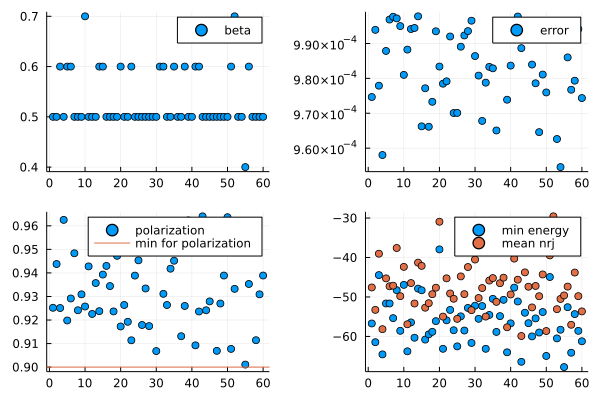

In [37]:
pb = scatter(inds, betas_seq, label="beta")
per = scatter(inds, errs_seq, label="error")
pp = scatter(inds, polars_seq, label = "polarization")
hline!([minpol], label="min for polarization")
pen = scatter(inds, ens_seq, label="min energy")
scatter!(inds, U_seq, label="mean nrj")
p = plot(pb, per, pp, pen)

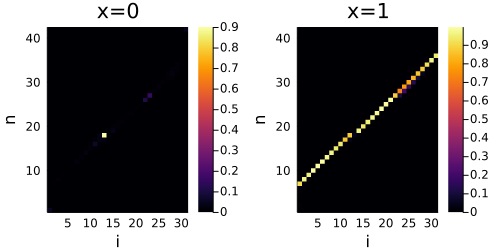

In [38]:
using Plots
i=1
idx0 = samples[i]
N = length(al[idx0][2])
bel = bels_seq[1:N+2,:,:,i];
p0 = heatmap(bel[:,1,:], xlabel="i", ylabel="n", title="x=0")
p1 = heatmap(bel[:,2,:], xlabel="i", ylabel="n", title="x=1")
p = plot(p0, p1, size=(500,250))

In [39]:
matches = []
entots_dca = []
entots_hhmer = []

for i in inds
    idx0 = samples[i]
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)    
    
    seqsol = BpAlignGpu.convert_soltosequence!(xnsols_seq[:,i], seq.strseq, N, L)

    solDCA = (fam[i,2:5]...,)
    append!(matches, seqsol == solDCA)
    endca = BpAlignGpu.compute_cost_function(pm.J, pm.H, String(solDCA[2]), L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    append!(entots_dca, endca) 
    
    enhhm = BpAlignGpu.compute_cost_function(pm.J, pm.H, al[idx0][4], L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    append!(entots_hhmer, enhhm) 
end

In [40]:
findall(check_seq .> 0) 

Int64[]

In [41]:
ndiffscedca = length(findall(matches .== false))
@show ndiffscedca
findall(matches .== false)

ndiffscedca = 6


6-element Vector{Int64}:
  3
  6
 20
 23
 37
 47

In [42]:
n_sce_worse_dca = length(findall(ens_seq .- entots_dca .> 0.0))
n_sce_better_dca =length(findall(ens_seq .- entots_dca .< 0.0))
@show n_sce_worse_dca, n_sce_better_dca
findall(ens_seq .- entots_dca .> 0.0)

(n_sce_worse_dca, n_sce_better_dca) = (6, 0)


6-element Vector{Int64}:
  3
  6
 20
 23
 37
 47

In [43]:
i=3
ens_seq[i], entots_dca[i], entots_hhmer[i]

(-44.46174f0, -45.32749f0, -41.31784f0)

In [44]:
n_sce_worse_hhmer = length(findall(ens_seq .- entots_hhmer .> 0.0))
n_sce_better_hhmer = length(findall(ens_seq .- entots_hhmer .< 0.0))
@show n_sce_worse_hhmer, n_sce_better_hhmer
findall(ens_seq .- entots_hhmer .> 0.0)

(n_sce_worse_hhmer, n_sce_better_hhmer) = (0, 22)


Int64[]

In [45]:
n_dca_worse_hhmer = length(findall(entots_dca .- entots_hhmer .> 0.0))
n_dca_better_hhmer = length(findall(entots_dca .- entots_hhmer .< 0.0))
@show n_dca_worse_hhmer, n_dca_better_hhmer

(n_dca_worse_hhmer, n_dca_better_hhmer) = (0, 22)


(0, 22)

# -------------- $\epsilon$ increasing --------------

In [46]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:mf  
beta=T(0.0)
verbose=false
xnsol = fill((0, 0), L);
epscoupling=(false, T(0.0), xnsol)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=mf
beta=0.0
verbose=false
epscoupling=false
-------------

In [47]:
#epsilons = [-0.001, -0.1, -0.5, -1.0, -5.0, -10.0, -50.0, -100.0, -500.0, -1000];
#epsilons = [-5.0, -10.0, -50.0, -100.0, -500.0, -1000];

epsilons = -0.0:-0.5:-2.0

0.0:-0.5:-2.0

In [48]:
betas_seq_eps = zeros(length(epsilons), length(inds))
errs_seq_eps = zeros(length(epsilons), length(inds))
polars_seq_eps = zeros(length(epsilons), length(inds))
ens_seq_eps = zeros(length(epsilons), length(inds))
check_seq_eps = zeros(length(epsilons), length(inds))
U_seq_eps = zeros(length(epsilons), length(inds))
S_seq_eps = zeros(length(epsilons), length(inds))

xnsols_seq_eps = fill((0,0), L, length(epsilons), length(inds))
bels_seq_eps = ones(Nmax+2,2,L, length(epsilons), length(inds));

In [49]:
for (i,idx0) in pairs(samples[inds])
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    for j in eachindex(epsilons)
        ϵ = epsilons[j]
        @show i, idx0, N, ϵ
    end
end

(i, idx0, N, ϵ) = (1, 46958, 40, 0.0)
(i, idx0, N, ϵ) = (1, 46958, 40, -0.5)
(i, idx0, N, ϵ) = (1, 46958, 40, -1.0)
(i, idx0, N, ϵ) = (1, 46958, 40, -1.5)
(i, idx0, N, ϵ) = (1, 46958, 40, -2.0)
(i, idx0, N, ϵ) = (2, 29277, 40, 0.0)
(i, idx0, N, ϵ) = (2, 29277, 40, -0.5)
(i, idx0, N, ϵ) = (2, 29277, 40, -1.0)
(i, idx0, N, ϵ) = (2, 29277, 40, -1.5)
(i, idx0, N, ϵ) = (2, 29277, 40, -2.0)
(i, idx0, N, ϵ) = (3, 37570, 40, 0.0)
(i, idx0, N, ϵ) = (3, 37570, 40, -0.5)
(i, idx0, N, ϵ) = (3, 37570, 40, -1.0)
(i, idx0, N, ϵ) = (3, 37570, 40, -1.5)
(i, idx0, N, ϵ) = (3, 37570, 40, -2.0)
(i, idx0, N, ϵ) = (4, 47888, 40, 0.0)
(i, idx0, N, ϵ) = (4, 47888, 40, -0.5)
(i, idx0, N, ϵ) = (4, 47888, 40, -1.0)
(i, idx0, N, ϵ) = (4, 47888, 40, -1.5)
(i, idx0, N, ϵ) = (4, 47888, 40, -2.0)
(i, idx0, N, ϵ) = (5, 40717, 39, 0.0)
(i, idx0, N, ϵ) = (5, 40717, 39, -0.5)
(i, idx0, N, ϵ) = (5, 40717, 39, -1.0)
(i, idx0, N, ϵ) = (5, 40717, 39, -1.5)
(i, idx0, N, ϵ) = (5, 40717, 39, -2.0)
(i, idx0, N, ϵ) = (6, 33094, 3

(i, idx0, N, ϵ) = (51, 47633, 40, -1.5)
(i, idx0, N, ϵ) = (51, 47633, 40, -2.0)
(i, idx0, N, ϵ) = (52, 34288, 37, 0.0)
(i, idx0, N, ϵ) = (52, 34288, 37, -0.5)
(i, idx0, N, ϵ) = (52, 34288, 37, -1.0)
(i, idx0, N, ϵ) = (52, 34288, 37, -1.5)
(i, idx0, N, ϵ) = (52, 34288, 37, -2.0)
(i, idx0, N, ϵ) = (53, 59691, 41, 0.0)
(i, idx0, N, ϵ) = (53, 59691, 41, -0.5)
(i, idx0, N, ϵ) = (53, 59691, 41, -1.0)
(i, idx0, N, ϵ) = (53, 59691, 41, -1.5)
(i, idx0, N, ϵ) = (53, 59691, 41, -2.0)
(i, idx0, N, ϵ) = (54, 15263, 38, 0.0)
(i, idx0, N, ϵ) = (54, 15263, 38, -0.5)
(i, idx0, N, ϵ) = (54, 15263, 38, -1.0)
(i, idx0, N, ϵ) = (54, 15263, 38, -1.5)
(i, idx0, N, ϵ) = (54, 15263, 38, -2.0)
(i, idx0, N, ϵ) = (55, 36914, 40, 0.0)
(i, idx0, N, ϵ) = (55, 36914, 40, -0.5)
(i, idx0, N, ϵ) = (55, 36914, 40, -1.0)
(i, idx0, N, ϵ) = (55, 36914, 40, -1.5)
(i, idx0, N, ϵ) = (55, 36914, 40, -2.0)
(i, idx0, N, ϵ) = (56, 50276, 39, 0.0)
(i, idx0, N, ϵ) = (56, 50276, 39, -0.5)
(i, idx0, N, ϵ) = (56, 50276, 39, -1.0)
(i, i

In [50]:
iters = 800
minpol = 0.90
nmax = 40
minbet = 0.02

0.02

In [ ]:
decim = zeros(length(epsilons), length(inds), Int);

In [ ]:
for (i,idx0) in pairs(samples[inds])

    #build seq, pm
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    xn = xnsols_seq[:,i] 
    for j in eachindex(epsilons)
        ϵ = epsilons[j]
        @show i, idx0, N, ϵ
        pa.epscoupling = (true, T(ϵ), xn)

        #build BP fields
        bpm = BPMessages(seq, pm, pa)
        bpb = BPBeliefs(N, L)
        lrf = LongRangeFields(N, L)
        af = AllFields(bpm, bpb, lrf)
        
        beta, err, polar, energy, check, U, S, xnsol, bel = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet)
        #decimation
        if check > 0
            decim[j,i] = 1
            
            println("need decimation: check=", check)
            BpAlignGpu.reshape_T3(bel,P)
            s, P = BpAlignGpu.decimate_post(seq, P, L, q, N, false);
            seqsol = BpAlignGpu.decodeposterior(P, seq.strseq)
            xnsol = BpAlignGpu.convertseqtoxnsol(outdec_decim, pm)
            c = BpAlignGpu.check_sr!(xnsol, L, N)
            check = sum(c)
            if check > 0
                println("problem during decimation: new check=", check)
            end
            energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
        end
 
        betas_seq_eps[j,i] = beta
        errs_seq_eps[j,i] = err
        polars_seq_eps[j,i] = polar
        ens_seq_eps[j,i] = energy
        check_seq_eps[j,i] = check
        U_seq_eps[j,i] = U
        S_seq_eps[j,i] = S

        bels_seq_eps[1:N+2, :, :, j, i] = bel
        xnsols_seq_eps[:,j,i] = xnsol
        @show i, idx0, ϵ, energy, U
        println("\n")
    end
    println("\n")
end


(i, idx0, N, ϵ) = (1, 46958, 40, 0.0)
beta = 0.0
converged: err=0.0009957254, tol=0.001, nbiter=59
(polar, energy) = (0.03885406f0, 40.408386f0)
beta = 0.1
converged: err=0.00099653, tol=0.001, nbiter=40
(polar, energy) = (0.051213626f0, 36.551735f0)
beta = 0.2
converged: err=0.0009815991, tol=0.001, nbiter=44
(polar, energy) = (0.07291951f0, 15.533146f0)
beta = 0.30000000000000004
converged: err=0.00097569823, tol=0.001, nbiter=43
(polar, energy) = (0.10644984f0, -18.823618f0)
beta = 0.4
converged: err=0.00097602606, tol=0.001, nbiter=295
(polar, energy) = (0.8001101f0, -56.71604f0)
beta = 0.5
converged: err=0.0009739399, tol=0.001, nbiter=75
(polar, energy) = (0.9252032f0, -56.71604f0)
(i, idx0, ϵ, energy, U) = (1, 46958, 0.0, -56.71604f0, -47.59159f0)


(i, idx0, N, ϵ) = (1, 46958, 40, -0.5)
beta = 0.0
converged: err=0.0009977818, tol=0.001, nbiter=57
(polar, energy) = (0.038524866f0, 30.266556f0)
beta = 0.1
converged: err=0.0009774566, tol=0.001, nbiter=41
(polar, energy) = (0.0510

converged: err=0.0009996817, tol=0.001, nbiter=58
(polar, energy) = (0.038634077f0, 39.52286f0)
beta = 0.1
converged: err=0.0009727776, tol=0.001, nbiter=40
(polar, energy) = (0.050993904f0, 34.604683f0)
beta = 0.2
converged: err=0.00096675754, tol=0.001, nbiter=45
(polar, energy) = (0.06984881f0, 44.812317f0)
beta = 0.30000000000000004
converged: err=0.0009882748, tol=0.001, nbiter=47
(polar, energy) = (0.095315196f0, 23.05198f0)
beta = 0.4
converged: err=0.0009821057, tol=0.001, nbiter=49
(polar, energy) = (0.12732269f0, 32.487156f0)
beta = 0.5
converged: err=0.0009937882, tol=0.001, nbiter=63
(polar, energy) = (0.17697102f0, 21.134869f0)
beta = 0.6
converged: err=0.0009980798, tol=0.001, nbiter=85
(polar, energy) = (0.24631353f0, 12.586815f0)
beta = 0.7
converged: err=0.0009927154, tol=0.001, nbiter=82
(polar, energy) = (0.3106829f0, 11.017578f0)
beta = 0.7999999999999999
converged: err=0.00099653, tol=0.001, nbiter=34
(polar, energy) = (0.3329944f0, 0.6457906f0)
beta = 0.8999999999

converged: err=0.0009993166, tol=0.001, nbiter=161
(polar, energy) = (0.67975855f0, -3.5221384f0)
beta = 1.9000000000000006
converged: err=0.000987947, tol=0.001, nbiter=91
(polar, energy) = (0.70675194f0, -4.485267f0)
beta = 2.0000000000000004
(polar, energy) = (0.7524506f0, -3.6664977f0)
decrease incbet: 0.05 ** polar_old: 0.70675194, polar: 0.7524506 ** energy_old: -4.485267, energy: -3.6664977
beta = 1.9500000000000004
(polar, energy) = (0.73826027f0, -3.6664977f0)
decrease incbet: 0.025 ** polar_old: 0.70675194, polar: 0.73826027 ** energy_old: -4.485267, energy: -3.6664977
beta = 1.9250000000000003
converged: err=0.0009278059, tol=0.001, nbiter=6
(polar, energy) = (0.7093805f0, -4.485267f0)
beta = 1.9500000000000002
(polar, energy) = (0.73967636f0, -3.6664977f0)
decrease incbet: 0.0125 ** polar_old: 0.7093805, polar: 0.73967636 ** energy_old: -4.485267, energy: -3.6664977
need decimation: check=1
(i, idx0, ϵ, energy, U) = (2, 29277, -2.0, -1.9839689f0, -2.38872f0)




(i, idx0, N

converged: err=0.0009907633, tol=0.001, nbiter=36
(polar, energy) = (0.049195543f0, 40.18273f0)
beta = 0.2
converged: err=0.00096714497, tol=0.001, nbiter=41
(polar, energy) = (0.065249f0, 41.911316f0)
beta = 0.30000000000000004
converged: err=0.0009913445, tol=0.001, nbiter=46
(polar, energy) = (0.08681803f0, 31.488922f0)
beta = 0.4
converged: err=0.0009990633, tol=0.001, nbiter=52
(polar, energy) = (0.11548536f0, 30.95028f0)
beta = 0.5
converged: err=0.0009977221, tol=0.001, nbiter=63
(polar, energy) = (0.15758099f0, 21.706676f0)
beta = 0.6
converged: err=0.0009927452, tol=0.001, nbiter=88
(polar, energy) = (0.22445297f0, 28.995811f0)
beta = 0.7
converged: err=0.0009996593, tol=0.001, nbiter=91
(polar, energy) = (0.2806851f0, 30.622585f0)
beta = 0.7999999999999999
converged: err=0.0009976625, tol=0.001, nbiter=42
(polar, energy) = (0.29811558f0, 17.494564f0)
beta = 0.8999999999999999
converged: err=0.0009791255, tol=0.001, nbiter=3
(polar, energy) = (0.30001923f0, 17.494564f0)
beta =

converged: err=0.0009737611, tol=0.001, nbiter=53
(polar, energy) = (0.8290208f0, -6.0436573f0)
beta = 1.6000000000000003
converged: err=0.0009832978, tol=0.001, nbiter=37
(polar, energy) = (0.8462317f0, -6.0436573f0)
beta = 1.7000000000000004
converged: err=0.0009890795, tol=0.001, nbiter=72
(polar, energy) = (0.86123973f0, -6.0436573f0)
beta = 1.8000000000000005
converged: err=0.0009771585, tol=0.001, nbiter=16
(polar, energy) = (0.86674845f0, -6.0436573f0)
beta = 1.9000000000000006
converged: err=0.000991255, tol=0.001, nbiter=87
(polar, energy) = (0.8764085f0, -4.845503f0)
beta = 2.0000000000000004
converged: err=0.00092595816, tol=0.001, nbiter=17
(polar, energy) = (0.87929827f0, -4.845503f0)
beta = 2.1000000000000005
converged: err=0.00097092986, tol=0.001, nbiter=89
(polar, energy) = (0.8866138f0, -4.845503f0)
beta = 2.2000000000000006
converged: err=0.0009072423, tol=0.001, nbiter=17
(polar, energy) = (0.8887712f0, -4.845503f0)
beta = 2.3000000000000007
converged: err=0.0009816

converged: err=0.0009989142, tol=0.001, nbiter=71
(polar, energy) = (0.18750098f0, 26.561382f0)
beta = 0.6
converged: err=0.0009957552, tol=0.001, nbiter=79
(polar, energy) = (0.2469674f0, 15.012493f0)
beta = 0.7
converged: err=0.0009953976, tol=0.001, nbiter=72
(polar, energy) = (0.29795197f0, 10.368468f0)
beta = 0.7999999999999999
converged: err=0.0009846687, tol=0.001, nbiter=34
(polar, energy) = (0.31749707f0, 0.073958464f0)
beta = 0.8999999999999999
converged: err=0.0009915233, tol=0.001, nbiter=18
(polar, energy) = (0.3277785f0, 0.073958464f0)
beta = 0.9999999999999999
converged: err=0.0009675026, tol=0.001, nbiter=4
(polar, energy) = (0.3304059f0, 4.080877f0)
beta = 1.0999999999999999
converged: err=0.0009972304, tol=0.001, nbiter=72
(polar, energy) = (0.3497398f0, 0.8966774f0)
beta = 1.2
converged: err=0.000995636, tol=0.001, nbiter=653
(polar, energy) = (0.7463378f0, -5.2951794f0)
beta = 1.3
converged: err=0.0009966493, tol=0.001, nbiter=61
(polar, energy) = (0.7944468f0, -5.2

converged: err=0.0009838939, tol=0.001, nbiter=52
(polar, energy) = (0.11936611f0, 24.83547f0)
beta = 0.5
converged: err=0.0009934902, tol=0.001, nbiter=65
(polar, energy) = (0.16283049f0, 22.870337f0)
beta = 0.6
converged: err=0.0009968579, tol=0.001, nbiter=101
(polar, energy) = (0.23568533f0, 18.899654f0)
beta = 0.7
converged: err=0.0009952784, tol=0.001, nbiter=80
(polar, energy) = (0.28627864f0, 12.760439f0)
beta = 0.7999999999999999
converged: err=0.0009928346, tol=0.001, nbiter=29
(polar, energy) = (0.30057806f0, 9.817348f0)
beta = 0.8999999999999999
converged: err=0.0009819269, tol=0.001, nbiter=18
(polar, energy) = (0.30833563f0, 10.386486f0)
beta = 0.9999999999999999
converged: err=0.00098598, tol=0.001, nbiter=28
(polar, energy) = (0.31477985f0, 9.388622f0)
beta = 1.0999999999999999
converged: err=0.0009954572, tol=0.001, nbiter=138
(polar, energy) = (0.29906386f0, 6.968993f0)
beta = 1.2
converged: err=0.0009977818, tol=0.001, nbiter=628
(polar, energy) = (0.81525797f0, -5.8

converged: err=0.00097072124, tol=0.001, nbiter=688
(polar, energy) = (0.9974215f0, -55.365654f0)
(i, idx0, ϵ, energy, U) = (7, 8776, -1.0, -55.365654f0, -55.017075f0)


(i, idx0, N, ϵ) = (7, 8776, 40, -1.5)
beta = 0.0
converged: err=0.0009919927, tol=0.001, nbiter=58
(polar, energy) = (0.03862067f0, 44.416378f0)
beta = 0.1
converged: err=0.0009651929, tol=0.001, nbiter=40
(polar, energy) = (0.051237263f0, 39.68594f0)
beta = 0.2
converged: err=0.0009938776, tol=0.001, nbiter=45
(polar, energy) = (0.07030869f0, 40.340977f0)
beta = 0.30000000000000004
converged: err=0.0009967387, tol=0.001, nbiter=48
(polar, energy) = (0.09597206f0, 17.301817f0)
beta = 0.4
converged: err=0.0009960234, tol=0.001, nbiter=50
(polar, energy) = (0.12798838f0, 31.726982f0)
beta = 0.5
converged: err=0.0009930432, tol=0.001, nbiter=69
(polar, energy) = (0.1810468f0, 27.032352f0)
beta = 0.6
converged: err=0.0009950399, tol=0.001, nbiter=97
(polar, energy) = (0.25878826f0, 21.620403f0)
beta = 0.7
converged: err=0.

In [53]:
sum(betas_seq_eps, dims=2)./length(inds)

5×1 Matrix{Float64}:
 0.5300000000000001
 0.8597916666666668
 1.751458333333333
 2.087291666666667
 2.0339583333333335

In [54]:
sum(errs_seq_eps, dims=2)./length(inds)

5×1 Matrix{Float64}:
 0.000983488808075587
 0.0010515286897619565
 0.0024383980004737773
 0.003828775944809119
 0.00446056437989076

In [55]:
sum(polars_seq_eps, dims=2)./length(inds)

5×1 Matrix{Float64}:
 0.9333117047945658
 0.9509398023287455
 0.8836975127458573
 0.7590520759423574
 0.7513531575600306

In [56]:
S_seq_eps 

5×60 Matrix{Float64}:
 0.892988  0.966408  0.93288   0.971036  …  0.936423  0.912776  1.00438
 1.13286   1.2469    1.38742   1.27687      1.05963   1.04138   1.03871
 0.340082  0.341979  1.81133   2.50622      1.75842   1.7679    1.48027
 0.329048  0.336381  0.285937  0.75668      0.408694  0.488644  0.775219
 0.326212  0.336157  0.277027  0.551043     0.377058  0.446977  0.747312

In [57]:
sum(ens_seq_eps, dims=2)./length(inds)

5×1 Matrix{Float64}:
 -55.82768859863281
 -54.54991675217946
 -31.463752452035745
  -7.915274368474881
  -3.957182680691282

In [58]:
sum(U_seq_eps, dims=2)./length(inds)

5×1 Matrix{Float64}:
 -48.02478342056274
 -50.8490671257178
 -30.69057701478402
  -7.453609348833561
  -3.6809843743840855

In [59]:
findall( [!(xnsols_seq[:,i] == xnsols_seq_eps[:,1,i]) for i in inds])

Int64[]

In [61]:
#mask = (check_seq_eps .== 0)

5×1 Matrix{Float64}:
 -55.82768859863281
 -54.54991675217946
 -31.463752452035745
  -7.915274368474881
  -3.957182680691282

In [65]:
ΔEs_seq_eps = zeros(length(epsilons), length(inds)) 
for i in inds
    for j in eachindex(epsilons)
        ΔEs_seq_eps[j,i] = ens_seq_eps[j,i] - ens_seq_eps[1,i]
    end
end
#ΔEs_mean = sum(ΔEs_seq_eps .* mask, dims=2) ./sum(mask, dims = 2)
ΔEs_mean = sum(ΔEs_seq_eps, dims=2)./length(inds)

5×1 Matrix{Float64}:
  0.0
  1.2777718464533487
 24.363936146597066
 47.91241423015793
 51.87050591794153

In [92]:
[mean(ΔEs_seq_eps[j,:]) for j in eachindex(epsilons)]
σΔEs = [std(ΔEs_seq_eps[j,:]) for j in eachindex(epsilons)]./sqrt(length(inds))

5-element Vector{Float64}:
 0.0
 0.959580498913305
 3.352689595769042
 1.8428728612323526
 1.08014248201661

In [66]:
ΔUs_seq_eps = zeros(length(epsilons), length(inds))  
for i in inds
    for j in eachindex(epsilons)
        ΔUs_seq_eps[j,i] = U_seq_eps[j,i] - U_seq_eps[1,i]
    end
end
#ΔUs_mean = sum(ΔUs_seq_eps .* mask, dims=2) ./sum(mask, dims = 2)
ΔUs_mean = sum(ΔUs_seq_eps, dims=2)./length(inds)

5×1 Matrix{Float64}:
  0.0
 -2.8242837051550547
 17.334206405778726
 40.57117407172918
 44.34379904617866

In [91]:
[mean(ΔUs_seq_eps[j,:]) for j in eachindex(epsilons)]
σΔUs = [std(ΔUs_seq_eps[j,:]) for j in eachindex(epsilons)]./sqrt(length(inds))

5-element Vector{Float64}:
 0.0
 0.9195935987075786
 3.275866530079986
 1.7860235159647984
 0.9547772805239131

In [67]:
#sum(mask, dims = 2)

In [68]:
Hdist_seq_eps = zeros(length(epsilons), length(inds))
for i in inds
    for j in eachindex(epsilons)
        Hdist_seq_eps[j,i] = sum(xnsols_seq_eps[:,j,i] .!= xnsols_seq[:,i])/L
    end
end
#Hdist_mean = sum(Hdist_seq_eps .* mask, dims = 2)./ sum(mask, dims=2)
Hdist_mean = sum(Hdist_seq_eps, dims = 2)./length(inds)

5×1 Matrix{Float64}:
 0.0
 0.04677419354838709
 0.40698924731182795
 0.7317204301075269
 0.7623655913978493

In [77]:
using Statistics

In [88]:
j=1
[mean(Hdist_seq_eps[j,:]) for j in eachindex(epsilons)]
σHdist = [std(Hdist_seq_eps[j,:]) for j in eachindex(epsilons)]./sqrt(length(inds))

5-element Vector{Float64}:
 0.0
 0.024803086414884247
 0.06173184501201542
 0.052360920826272396
 0.051821876626044906

In [69]:
#nbsol_mean = sum(mask, dims=2)./length(inds)

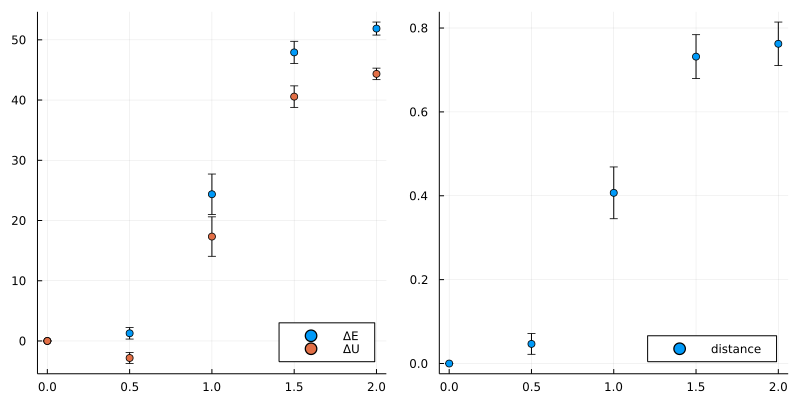

In [97]:
pΔ = scatter(-epsilons, ΔEs_mean, yerr=σΔEs, label="ΔE", legend=:bottomright)
scatter!(-epsilons, ΔUs_mean, yerr=σΔUs, label="ΔU")
pdist = scatter(-epsilons, Hdist_mean, yerr=σHdist, label="distance", legend=:bottomright)
#scatter!(-epsilons, nbsol_mean, label="fraction solutions found")
plot(pΔ, pdist, size=(800,400))

In [97]:
CUDA.allowscalar(true)

In [136]:
(ni, xi, nj, xj, i, j) = (3,1,2,0,20,21)
BpAlignGpu.χlr(ni, xi, nj, xj, i, j)

false

In [138]:
BpAlignGpu.χsr(ni, xi, nj, xj, N, 0.0, 0.0, 0.0)

0.0

In [139]:
af.bpb.conditional[ni, xi, nj, xj, i, j]

0.0f0

In [144]:
@tullio tmp[ni, xi, nj, xj, i] := BpAlignGpu.χsr(ni, xi, nj, xj, N, 0.0, 0.0, 0.0) * af.bpb.conditional[ni, xi, nj, xj, i, i+1]


42×2×42×2×30 CuArray{Float64, 5, CUDA.Mem.DeviceBuffer}:
[:, :, 1, 1, 1] =
 1.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

[:, :, 2, 1, 1] =
 0.0  0.0
 0.0  1.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

[:, :, 3, 1, 1] =
 0.0  0.0
 0.0  0.0
 0.0  1.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

;;; … 

[:, :, 40, 1, 1] =
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.

In [146]:
for i=1:L-1
    if tmp[:,:,:,:,i] != af.bpb.conditional[:,:,:,:, i, i+1]
        @show i
    end
end

In [122]:
using Tullio

In [123]:
@tullio scra[ni, xi, nj, xj, i, j] := af.bpb.conditional[ni, xi, nj, xj, i, j] * BpAlignGpu.χlr(ni, xi, nj, xj, i, j)

42×2×42×2×31×31 CuArray{Float32, 6, CUDA.Mem.DeviceBuffer}:
[:, :, 1, 1, 1, 1] =
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

[:, :, 2, 1, 1, 1] =
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

[:, :, 3, 1, 1, 1] =
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

;;; … 

[:, :, 40, 1, 1, 1] =
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.

In [133]:
for i=1:L
    for j=1:L
        if !(scra[:,:,:,:,i,j] == af.bpb.conditional[:,:,:,:,i,j])
            @show i,j
        end
    end
    println("\n")
end

(i, j) = (1, 1)
(i, j) = (1, 2)


(i, j) = (2, 1)
(i, j) = (2, 2)
(i, j) = (2, 3)


(i, j) = (3, 2)
(i, j) = (3, 3)
(i, j) = (3, 4)


(i, j) = (4, 3)
(i, j) = (4, 4)
(i, j) = (4, 5)


(i, j) = (5, 4)
(i, j) = (5, 5)
(i, j) = (5, 6)


(i, j) = (6, 5)
(i, j) = (6, 6)
(i, j) = (6, 7)


(i, j) = (7, 6)
(i, j) = (7, 7)
(i, j) = (7, 8)


(i, j) = (8, 7)
(i, j) = (8, 8)
(i, j) = (8, 9)


(i, j) = (9, 8)
(i, j) = (9, 9)
(i, j) = (9, 10)


(i, j) = (10, 9)
(i, j) = (10, 10)
(i, j) = (10, 11)


(i, j) = (11, 10)
(i, j) = (11, 11)
(i, j) = (11, 12)


(i, j) = (12, 11)
(i, j) = (12, 12)
(i, j) = (12, 13)


(i, j) = (13, 12)
(i, j) = (13, 13)
(i, j) = (13, 14)


(i, j) = (14, 13)
(i, j) = (14, 14)
(i, j) = (14, 15)


(i, j) = (15, 14)
(i, j) = (15, 15)
(i, j) = (15, 16)


(i, j) = (16, 15)
(i, j) = (16, 16)
(i, j) = (16, 17)


(i, j) = (17, 16)
(i, j) = (17, 17)
(i, j) = (17, 18)


(i, j) = (18, 17)
(i, j) = (18, 18)
(i, j) = (18, 19)


(i, j) = (19, 18)
(i, j) = (19, 19)
(i, j) = (19, 20)


(i, j)